# Building a Style Classifier with Color Features

## Introduction

Can a computer identify an artwork's artistic movement just from its colors? In this lesson, we'll build a **machine learning classifier** that predicts artistic style based on color features.

### What You'll Learn

- Extracting color features for machine learning
- Building a training dataset from WikiArt
- Training a simple classifier
- Evaluating model performance
- Understanding what colors define each movement

### Machine Learning Basics

We'll use **supervised learning**:
1. **Features**: Color statistics (hue, saturation, brightness, etc.)
2. **Labels**: Artistic movement (Impressionism, Expressionism, etc.)
3. **Model**: Random Forest Classifier (easy to interpret)

Let's build our art style classifier!

## Setup

In [4]:
from renoir import ArtistAnalyzer
from renoir.color import ColorExtractor, ColorAnalyzer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Initialize
artist_analyzer = ArtistAnalyzer()
color_extractor = ColorExtractor()
color_analyzer = ColorAnalyzer()

print("Loading WikiArt dataset...")
dataset = artist_analyzer._load_dataset()
print(f"Loaded {len(dataset)} artworks")

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

Loading WikiArt dataset...
Loading WikiArt dataset...


Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/45 [00:00<?, ?it/s]

✓ Loaded 81444 artworks
Loaded 81444 artworks


## Part 1: Feature Extraction

First, we need to convert color information into numerical features that ML models can understand.

In [5]:
def extract_color_features(image, n_colors=5):
    """
    Extract numerical color features from an image.
    
    Returns a dictionary of features suitable for ML.
    """
    try:
        # Extract dominant colors
        palette = color_extractor.extract_dominant_colors(image, n_colors=n_colors)
        
        if not palette:
            return None
        
        # Basic statistics
        stats = color_analyzer.analyze_palette_statistics(palette)
        temp_dist = color_analyzer.analyze_color_temperature_distribution(palette)
        
        # Create feature dictionary
        features = {
            # Central tendencies
            'mean_hue': stats['mean_hue'],
            'mean_saturation': stats['mean_saturation'],
            'mean_brightness': stats['mean_value'],
            
            # Spread/variation
            'hue_std': stats.get('std_hue', 0),
            'saturation_std': stats.get('std_saturation', 0),
            'brightness_std': stats.get('std_value', 0),
            
            # Temperature
            'warm_ratio': temp_dist['warm_percentage'] / 100,
            'cool_ratio': temp_dist['cool_percentage'] / 100,
            'neutral_ratio': temp_dist['neutral_percentage'] / 100,
            
            # Derived scores
            'color_diversity': color_analyzer.calculate_color_diversity(palette),
            'saturation_score': color_analyzer.calculate_saturation_score(palette),
            'brightness_score': color_analyzer.calculate_brightness_score(palette),
            
            # RGB means
            'mean_red': np.mean([c[0] for c in palette]),
            'mean_green': np.mean([c[1] for c in palette]),
            'mean_blue': np.mean([c[2] for c in palette]),
        }
        
        return features
    
    except Exception as e:
        return None

# Test feature extraction
test_works = artist_analyzer.extract_artist_works('claude-monet', limit=1)
if test_works:
    features = extract_color_features(test_works[0]['image'])
    print("Example features:")
    for key, value in features.items():
        print(f"  {key}: {value:.2f}")

✓ Found 1 works by claude-monet
Example features:
  mean_hue: 27.24
  mean_saturation: 58.37
  mean_brightness: 52.94
  hue_std: 82.96
  saturation_std: 24.63
  brightness_std: 18.62
  warm_ratio: 0.80
  cool_ratio: 0.20
  neutral_ratio: 0.00
  color_diversity: 0.38
  saturation_score: 58.37
  brightness_score: 52.94
  mean_red: 131.00
  mean_green: 104.40
  mean_blue: 67.40


## Part 2: Building the Training Dataset

In [6]:
# Define movements to classify
movements = [
    ('impressionism', 'Impressionism'),
    ('expressionism', 'Expressionism'),
    ('baroque', 'Baroque'),
    ('romanticism', 'Romanticism'),
    ('post-impressionism', 'Post-Impressionism')
]

# Collect training data
training_data = []
training_labels = []

samples_per_movement = 30  # Adjust based on time/resources

for style_key, style_name in movements:
    print(f"\nCollecting {style_name} samples...")
    
    # Find style index
    style_names = dataset.features['style'].names
    target_idx = None
    for idx, name in enumerate(style_names):
        if style_key.lower() in name.lower():
            target_idx = idx
            break
    
    if target_idx is None:
        print(f"  Style not found: {style_key}")
        continue
    
    # Collect samples
    count = 0
    for item in dataset:
        if item['style'] == target_idx:
            features = extract_color_features(item['image'])
            if features:
                training_data.append(features)
                training_labels.append(style_name)
                count += 1
                if count >= samples_per_movement:
                    break
    
    print(f"  Collected {count} samples")

print(f"\n{'='*50}")
print(f"Total samples: {len(training_data)}")
print(f"Classes: {set(training_labels)}")


  Collected 30 samples

  Collected 30 samples

  Collected 30 samples

  Collected 30 samples

  Style not found: post-impressionism

Total samples: 120
Classes: {'Impressionism', 'Expressionism', 'Romanticism', 'Baroque'}


In [7]:
# Convert to DataFrame
df = pd.DataFrame(training_data)
df['movement'] = training_labels

print("Dataset shape:", df.shape)
print("\nClass distribution:")
print(df['movement'].value_counts())

# Preview
print("\nFeature statistics:")
print(df.describe().round(2))

Dataset shape: (120, 16)

Class distribution:
movement
Impressionism    30
Expressionism    30
Baroque          30
Romanticism      30
Name: count, dtype: int64

Feature statistics:
       mean_hue  mean_saturation  mean_brightness  hue_std  saturation_std  \
count    120.00           120.00           120.00   120.00          120.00   
mean      70.02            29.78            55.26    25.70           10.84   
std       64.27            19.75             9.40    31.05            7.44   
min        0.00             0.00            22.43     0.00            0.00   
25%       34.25            14.98            49.78     5.59            5.19   
50%       48.26            26.30            56.16    11.75            9.07   
75%       84.43            41.94            61.69    33.36           15.26   
max      351.44            85.22            78.75   130.39           37.19   

       brightness_std  warm_ratio  cool_ratio  neutral_ratio  color_diversity  \
count          120.00       120.0 

## Part 3: Exploratory Data Analysis

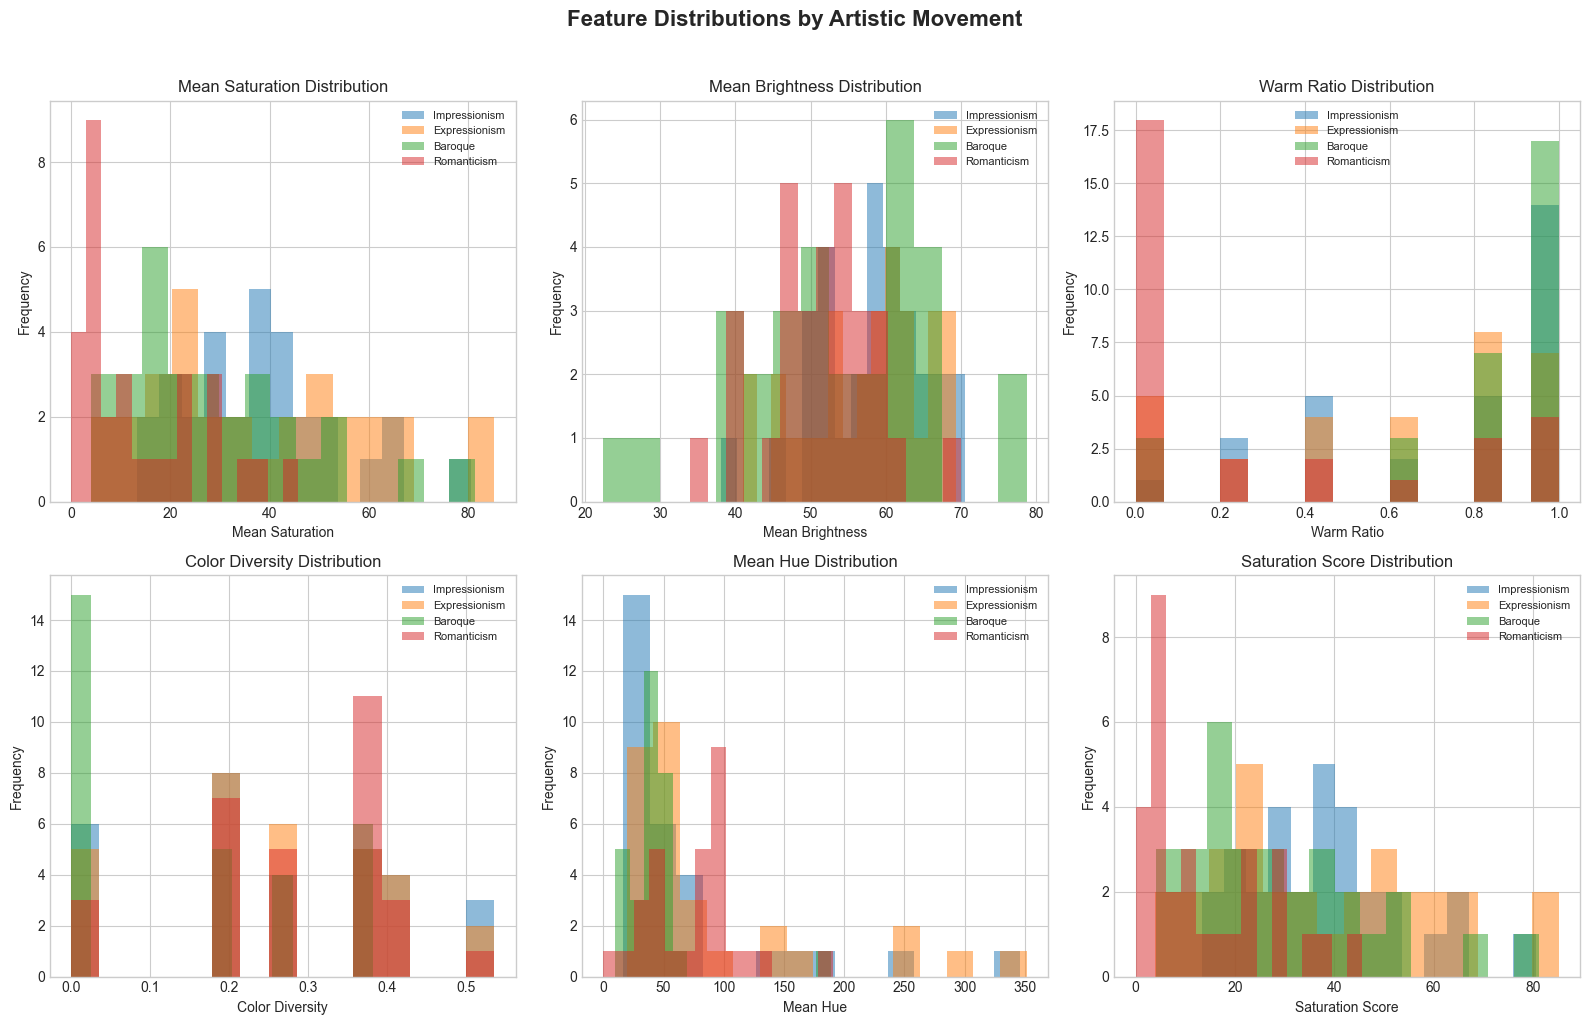

In [8]:
# Visualize feature distributions by movement
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

features_to_plot = ['mean_saturation', 'mean_brightness', 'warm_ratio', 
                    'color_diversity', 'mean_hue', 'saturation_score']

for ax, feature in zip(axes.flat, features_to_plot):
    for movement in df['movement'].unique():
        subset = df[df['movement'] == movement]
        ax.hist(subset[feature], alpha=0.5, label=movement, bins=15)
    
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Frequency')
    ax.set_title(f'{feature.replace("_", " ").title()} Distribution')
    ax.legend(fontsize=8)

plt.suptitle('Feature Distributions by Artistic Movement', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Part 4: Training the Classifier

In [9]:
# Prepare data for training
feature_columns = [col for col in df.columns if col != 'movement']
X = df[feature_columns].values
y = df['movement'].values

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
print("\nTraining Random Forest classifier...")
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train_scaled, y_train)

print("Training complete!")

Training samples: 90
Test samples: 30

Training Random Forest classifier...
Training complete!


## Part 5: Evaluating the Classifier

In [10]:
# Make predictions
y_pred = clf.predict(X_test_scaled)

# Print classification report
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred))

# Accuracy
accuracy = (y_pred == y_test).mean()
print(f"\nOverall Accuracy: {accuracy:.2%}")

CLASSIFICATION REPORT
               precision    recall  f1-score   support

      Baroque       0.50      0.50      0.50         8
Expressionism       0.29      0.29      0.29         7
Impressionism       0.44      0.50      0.47         8
  Romanticism       0.67      0.57      0.62         7

     accuracy                           0.47        30
    macro avg       0.47      0.46      0.47        30
 weighted avg       0.47      0.47      0.47        30


Overall Accuracy: 46.67%


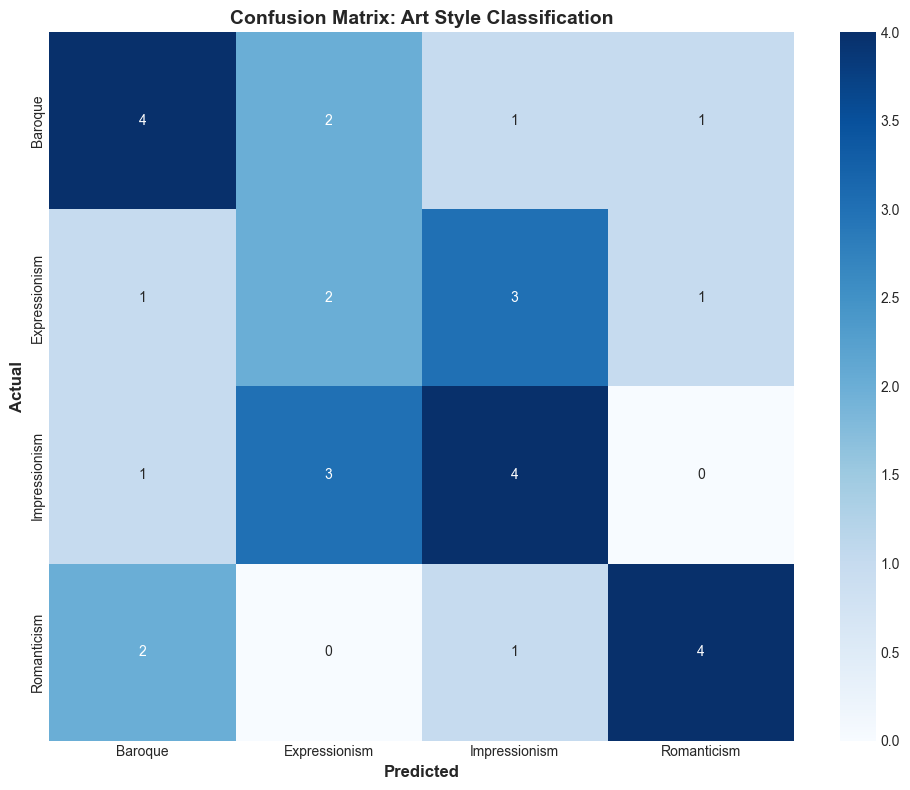


Interpretation:
- Diagonal = correct predictions
- Off-diagonal = misclassifications
- Rows = actual class, Columns = predicted class


In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = sorted(set(y_test))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix: Art Style Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Diagonal = correct predictions")
print("- Off-diagonal = misclassifications")
print("- Rows = actual class, Columns = predicted class")

## Part 6: Feature Importance

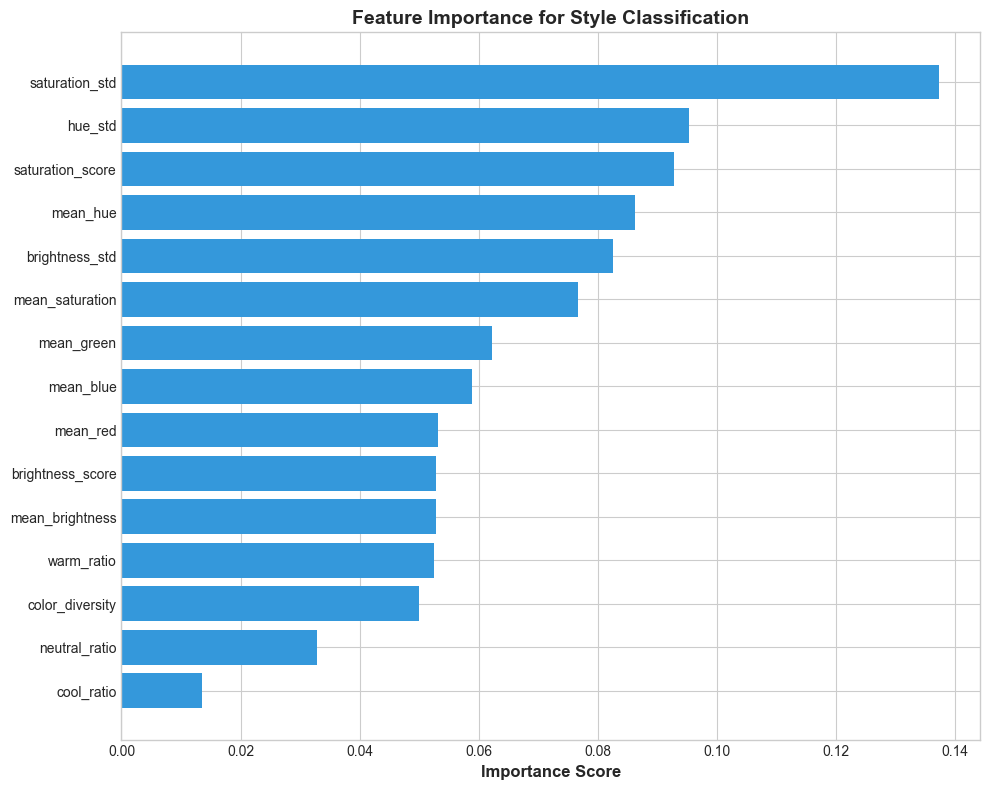


Top 5 Most Important Features:
         feature  importance
  brightness_std    0.082537
        mean_hue    0.086339
saturation_score    0.092808
         hue_std    0.095402
  saturation_std    0.137358


In [12]:
# Which features are most important for classification?
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='#3498db')
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.title('Feature Importance for Style Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance_df.tail().to_string(index=False))

## Part 7: Making Predictions on New Artworks

In [13]:
def predict_style(image, classifier, scaler, feature_columns):
    """
    Predict the artistic style of an image.
    """
    # Extract features
    features = extract_color_features(image)
    if not features:
        return None, None
    
    # Create feature vector
    X = np.array([[features[col] for col in feature_columns]])
    X_scaled = scaler.transform(X)
    
    # Predict
    prediction = classifier.predict(X_scaled)[0]
    probabilities = classifier.predict_proba(X_scaled)[0]
    
    return prediction, dict(zip(classifier.classes_, probabilities))

# Test on some artworks
test_artists = [
    ('claude-monet', 'Monet'),
    ('edvard-munch', 'Munch'),
    ('vincent-van-gogh', 'Van Gogh')
]

print("\nSTYLE PREDICTIONS FOR TEST ARTWORKS")
print("="*60)

for artist_id, artist_name in test_artists:
    works = artist_analyzer.extract_artist_works(artist_id, limit=3)
    
    if works:
        print(f"\n{artist_name}:")
        for i, work in enumerate(works, 1):
            prediction, probs = predict_style(
                work['image'], clf, scaler, feature_columns
            )
            if prediction:
                confidence = max(probs.values())
                print(f"  Work {i}: {prediction} ({confidence:.1%} confidence)")


STYLE PREDICTIONS FOR TEST ARTWORKS
✓ Found 3 works by claude-monet

Monet:
  Work 1: Expressionism (50.0% confidence)
  Work 2: Impressionism (66.0% confidence)
  Work 3: Impressionism (68.7% confidence)
✓ Found 3 works by edvard-munch

Munch:
  Work 1: Romanticism (60.0% confidence)
  Work 2: Romanticism (42.0% confidence)
  Work 3: Impressionism (57.1% confidence)
✓ Found 3 works by vincent-van-gogh

Van Gogh:
  Work 1: Impressionism (51.7% confidence)
  Work 2: Expressionism (39.6% confidence)
  Work 3: Expressionism (32.5% confidence)


## Part 8: Key Insights

### What We've Learned

1. **Color alone carries style information** - We can predict movement from colors
2. **Some features are more important** - Saturation and brightness often distinguish movements
3. **Some styles are easier to classify** - Distinctive palettes are easier to identify
4. **Confusion patterns make sense** - Similar movements (Impressionism/Post-Impressionism) get confused

### Limitations

- Color is just one aspect of style
- Artists don't always conform to movement norms
- Limited training data
- No composition/brushwork features

### Improvements to Try

- Add more training samples
- Include texture features
- Try deep learning (CNNs)
- Add more color features (histograms, etc.)

In [ ]:
# YOUR CODE HERE
# Exercises:
# 1. Add more movements to the classifier
# 2. Try a different ML model (SVM, Neural Network)
# 3. Add new color features
# 4. Build an artist classifier instead of movement classifier



---

## Conclusion

Congratulations! You've built a complete machine learning pipeline that:

1. **Extracts** numerical features from color palettes
2. **Builds** a training dataset from WikiArt
3. **Trains** a Random Forest classifier
4. **Evaluates** model performance with metrics and visualizations
5. **Identifies** which color features best distinguish movements
6. **Predicts** styles for new artworks

**Key Insight**: While color alone isn't perfect for style classification, it captures meaningful information about artistic movements—and this is just the beginning of computational art history!